<a href="https://colab.research.google.com/github/Karasiari/Graphs/blob/main/Exps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install "git+https://github.com/Karasiari/graphmcfexps.git"

  Cloning https://github.com/Karasiari/graphmcfexps.git to /tmp/pip-req-build-vy4bbc7h
  Running command git clone --filter=blob:none --quiet https://github.com/Karasiari/graphmcfexps.git /tmp/pip-req-build-vy4bbc7h
  Resolved https://github.com/Karasiari/graphmcfexps.git to commit 8942b625f89edd6a42be39d594d9c2a3c2d164d5
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for graphmcfexps: filename=graphmcfexps-0.1.0-py3-none-any.whl size=11529 sha256=27befd3519985d13831cfc681c60df3fa69c7034d2423ff9361ba37f66ebda0d
  Stored in directory: /tmp/pip-ephem-wheel-cache-jcrzran_/wheels/09/cf/d5/20f73fe3b91fddd32c1c90d1bb788e0d83851f63661cafc4ad
Successfully built graphmcfexps


In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import os
from google.colab import files

# две функции - читалки hu графов в мультиграфы

BITRATE_DENOMINATOR = 100

def hu_csv_to_graphs(path, demands_path, capacity_path):
  Network = pd.read_csv(path, header=None, names = ['id', 'source', 'target', 'length'])
  Traffic = pd.read_csv(demands_path, header=None, names = ['id', 'source', 'target', 'bitrate'])
  Capacity = pd.read_csv(capacity_path, header=None, names = ['name', 'value'])
  network = Network.iloc[1:].copy()
  traffic = Traffic.iloc[1:].copy()
  capacity = Capacity.iloc[1:].copy()

  network['source'] = network['source'].astype(int)
  network['target'] = network['target'].astype(int)
  traffic['source'] = traffic['source'].astype(int)
  traffic['target'] = traffic['target'].astype(int)
  traffic['bitrate'] = traffic['bitrate'].astype(float) / BITRATE_DENOMINATOR
  capacity_value = float(capacity[capacity['name']=='NumberOfWavelengths']['value'])

  sources = network['source'].tolist()
  targets = network['target'].tolist()
  sources_traffic = traffic['source'].tolist()
  targets_traffic = traffic['target'].tolist()
  bitrates_traffic = traffic['bitrate'].tolist()

  unique_vertices = set()
  for source, target in zip(sources, targets):
    unique_vertices.add(source)
    unique_vertices.add(target)
  vertex_mapping = {old: new for new, old in enumerate(unique_vertices)}
  num_vertices = len(unique_vertices)

  adj_edges = []
  traffic_edges = []

  for source, target in zip(sources, targets):
    new_source = vertex_mapping[source]
    new_target = vertex_mapping[target]
    adj_edges.append((new_source, new_target, {"capacity": capacity_value}))
  for source, target, bitrate in zip(sources_traffic, targets_traffic, bitrates_traffic):
    new_source = vertex_mapping[source]
    new_target = vertex_mapping[target]
    traffic_edges.append((new_source, new_target, {"weight": bitrate}))

  adj_graph = nx.MultiGraph()
  adj_graph.add_edges_from(adj_edges)
  traffic_graph = nx.MultiDiGraph()
  traffic_graph.add_nodes_from(range(adj_graph.number_of_nodes()))
  traffic_graph.add_edges_from(traffic_edges)

  return adj_graph, traffic_graph, capacity_value

def get_hu_graphs(base_path, specified_graphs, specified):
  Graphs = {}
  csv_tables = []
  for folder_name in os.listdir(base_path):
    if folder_name in specified_graphs or not specified:
      folder_path = os.path.join(base_path, folder_name)
      csv_path = os.path.join(folder_path, 'links.csv')
      csv_path_demands = os.path.join(folder_path, 'demands.csv')
      csv_path_capacity = os.path.join(folder_path, 'params.csv')
      csv_tables.append(folder_name)

      adj_graph, traffic_graph, capacity_value = hu_csv_to_graphs(csv_path, csv_path_demands, csv_path_capacity)
      Graphs[folder_name] = {'adj_graph': adj_graph, 'traffic_graph': traffic_graph, 'capacity_value': capacity_value}

  return Graphs

path_to_folder = '/content/drive/MyDrive/Кола'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Tuple, Dict, Any, Optional

def visualize_parametrized_bars(
    data_dict: Dict[str, List[Tuple[str, float]]],
    title: str = "Сравнение по параметрам",
    xlabel: str = "Методы",
    ylabel: str = "Значения",
    color_dict: Optional[Dict[str, str]] = None,
    default_color: str = 'lightblue',
    show_values: bool = True,
    figsize: Tuple[int, int] = (15, 6),
    share_y: bool = True,
    bar_width: float = 0.7,
    param_names: Optional[List[str]] = None
):
    param_values = list(data_dict.keys())
    n_params = len(param_values)

    if param_names is None:
        param_names = [str(p) for p in param_values]

    fig, axes = plt.subplots(1, n_params, figsize=figsize,
                             sharey=share_y, squeeze=False)
    axes = axes.flatten()

    if share_y:
        all_values = []
        for param_data in data_dict.values():
            all_values.extend([v for _, v in param_data])
        max_value = max(all_values)
        min_value = min(all_values)
        y_margin = (max_value - min_value)

    first_param_data = data_dict[param_values[0]]
    categories = [name for name, _ in first_param_data]
    n_categories = len(categories)

    for idx, (param_value, param_name) in enumerate(zip(param_values, param_names)):
        ax = axes[idx]
        data = data_dict[param_value]

        names, values = zip(*data)

        colors_to_use = []
        if color_dict is not None:
            for name in names:
                colors_to_use.append(color_dict.get(name, default_color))
        else:
            colors_to_use = [default_color] * len(names)

        x_positions = np.arange(len(names))
        bars = ax.bar(x_positions, values, color=colors_to_use,
                      edgecolor='black', width=bar_width)

        if show_values:
            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.2f}', ha='center', va='bottom',
                       fontweight='bold', fontsize=9)

        ax.set_title(f"{param_name}", fontsize=12, fontweight='bold')
        ax.set_xlabel(xlabel, fontsize=10)
        if idx == 0:
            ax.set_ylabel(ylabel, fontsize=10)

        ax.set_xticks(x_positions)
        ax.set_xticklabels(names, rotation=45, ha='right', fontsize=9)

        ax.grid(axis='y', alpha=0.3, linestyle='--')

        if share_y:
            ax.set_ylim([min(0, min_value - y_margin), max_value + y_margin])

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    fig.suptitle(title, fontsize=14, fontweight='bold', y=1.02)

    plt.tight_layout()
    plt.show()

def visualize_lines_simple(
    data_dict: Dict[Any, Dict[str, List[float]]],
    title: str = "График средних значений",
    xlabel: str = "Параметры",
    ylabel: str = "Среднее значение",
    colors: Optional[List[str]] = None,
    figsize: Tuple[int, int] = (10, 6),
    marker: str = 'o',
    linewidth: int = 2,
    markersize: int = 6,
    grid: bool = True,
    legend: bool = True,
    show_values: bool = False,
    value_decimal_places: int = 2
):
    if not data_dict:
        print("Нет данных для отображения")
        return

    fig, ax = plt.subplots(figsize=figsize)

    all_line_types = set()
    for inner_dict in data_dict.values():
        all_line_types.update(inner_dict.keys())
    all_line_types = sorted(list(all_line_types))

    if colors is None:
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                 '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

    x_values = sorted(data_dict.keys())

    for i, line_type in enumerate(all_line_types):
        y_values = []

        for x in x_values:
            if line_type in data_dict[x] and data_dict[x][line_type]:
                values = data_dict[x][line_type]
                mean_val = sum(values) / len(values)
                y_values.append(mean_val)
            else:
                y_values.append(np.nan)

        color = colors[i % len(colors)]

        line, = ax.plot(x_values, y_values,
                       marker=marker,
                       linewidth=linewidth,
                       markersize=markersize,
                       color=color,
                       label=line_type)

        if show_values:
            for x, y in zip(x_values, y_values):
                if not np.isnan(y):
                    if value_decimal_places == 0:
                        text = f'{y:.0f}'
                    else:
                        text = f'{y:.{value_decimal_places}f}'

                    ax.text(x, y, text,
                           ha='center', va='bottom',
                           fontsize=8,
                           bbox=dict(boxstyle='round,pad=0.2',
                                    facecolor='white',
                                    alpha=0.7))

    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)

    if legend:
        ax.legend(fontsize=10)

    if grid:
        ax.grid(True, alpha=0.3, linestyle='--')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()


  type_colors = {
        "initial": "#FF6B6B",     # красный
        "min_Lalpha_cut": "#6B5B95",   # фиолетовый
        "random": "#88B04B"        # зеленый
    }

In [ ]:
import warnings
warnings.filterwarnings('ignore')

Подбираем оптимальное число новых ресурсов для чувствительности теста на расширение

In [ ]:
import networkx as nx
import numpy as np

from graphmcfexps.expand_test import *

def get_sequence(graph, type):
  if type == "min_Lalpha_cut":
    sequence = graph.generate_cut(type="min_Lalpha")
  elif type == "random":
    sequence = [(source, target) for source, target in graph.graph.edges()]
  return sequence

def get_mean(graph, sequence, number_to_add, additional_capacities, tries):
  gammas = []
  for i in range(tries):
    random.shuffle(sequence)
    sequences_to_edges(sequence[:number_to_add], additional_capacities, graph)
    gamma_for_test = graph.solve_mcfp()
    gammas.append(gamma_for_test)
    graph.restore_graph()
  return float(np.mean(gammas))

graphs_for_test_names = ['cola_t3', 'cola_t2']#, 'cola_t8', 'cola_t10', '2024_north', '2024_south', '2024_southwest']
graphs_for_test = get_hu_graphs(path_to_folder, graphs_for_test_names, True)
edges_fractions = [0.1, 0.25, 0.5, 1.0]
types_for_optimal = ["initial", "min_Lalpha_cut", "random"]
alpha_type = "min_Lalpha"
tries_for_random = 10
general_results = {fraction: {} for fraction in edges_fractions}

for name in graphs_for_test_names:
  graph = graphs_for_test[name]
  adj_graph, traffic_graph, capacity_value = graph['adj_graph'], graph['traffic_graph'], graph['capacity_value']
  graph_for_exp = GraphMCFexps(adj_graph, traffic_graph)
  number_in_mincut = get_number_in_mincut(graph_for_exp, alpha_type)
  graph_results = {}

  for fraction in edges_fraction:
    number_to_add = int(number_in_mincut * fraction)
    additional_capacities = [capacity_value] * number_to_add
    for type in types_for_optimal:
      if type == "initial":
        gamma = graph_for_exp.solve_mcfp()
      elif type in ("min_Lalpha_cut", "random"):
        sequence = get_sequence(graph_for_exp, type)
        gamma = get_mean(graph_for_exp, sequence, number_to_add, additional_capacities, tries_for_random)
      graph_results[fraction] = (type, gamma)

  print(f'Чувствительность теста на графе {name}')
  visualize_parametrized_bars(
      data_dict=graph_results,
      title="Чувствительность теста в зависимости от доли новых ресурсов",
      xlabel="Метод",
      ylabel="Gamma",
      color_dict=product_colors,
      default_color='lightgray',
      show_values=True,
      figsize=(15, 6),
      share_y=True,
      bar_width=0.6,
      rotation=45,
      title_fontsize=16,
      param_title_fontsize=12,
      value_fontsize=10,
      xtick_fontsize=9
    )
  for fraction, value in graph_results.items():
    for type, gamma in value:
      if general_results[fraction].get(type) is None:
        general_results[fraction][type] = [gamma]
      else:
        general_results[fraction][type].append(gamma)

print(f'Общая сводка по графам')
visualize_lines_simple(
        data_dict=general_results,
        title="Сравнение методов на чувствительность",
        xlabel="Доля новых ресурсов",
        ylabel="Улучшение относительно входа",
        colors=["#FF6B6B", "#6B5B95", "#88B04B"],
        marker='s',
        linewidth=3
    )

Доступные типы на распределение ресурсов: ['initial', 'alpha', 'random', 'min_cut', 'min_Lalpha_cut', 'betweenness_unweighted']

--------- Проводим тест на графе cola_t3 ---------

Добавим 3 новых мультиребер с capacity=80.0

Для графа cola_t3 результаты теста:

initial: 1.2698412697100192
alpha: 1.2820512819525094
random: 1.2698412690317562
min_Lalpha_cut: 1.2698412684259384
betweenness_unweighted: 1.2698412688388467

Результаты gamma для типов в порядке убывания - от лучших к худшим: alpha, initial, random, betweenness_unweighted, min_Lalpha_cut




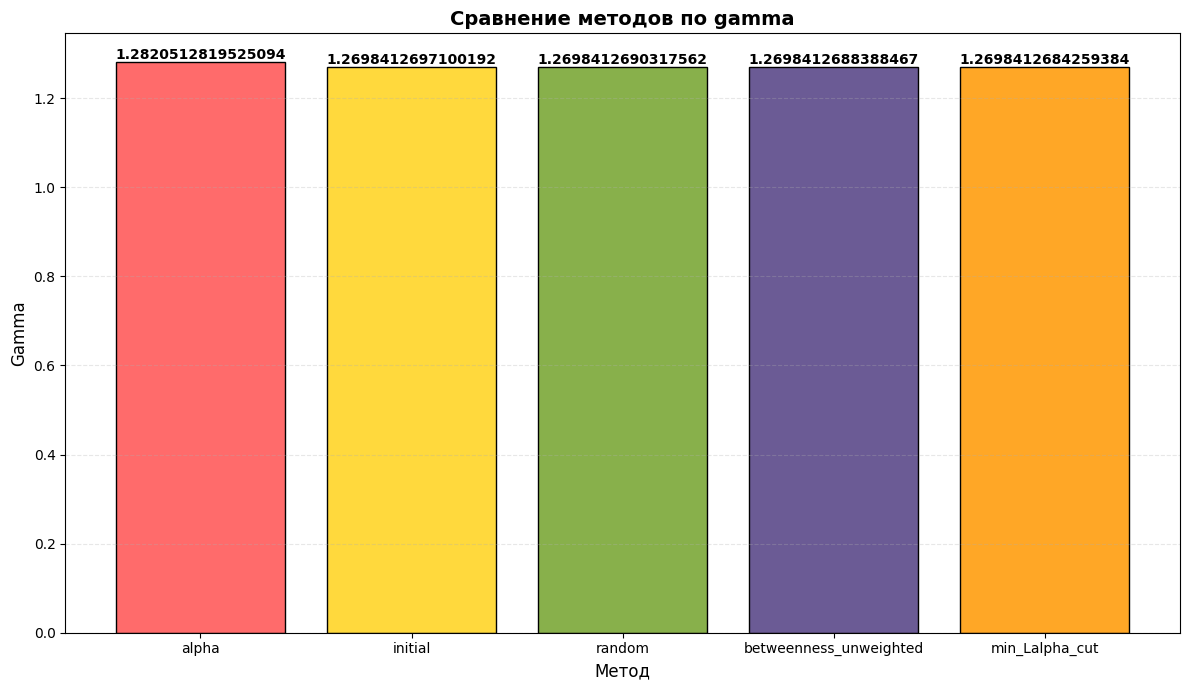

--------- Проводим тест на графе cola_t2 ---------

Добавим 3 новых мультиребер с capacity=80.0

Для графа cola_t2 результаты теста:

initial: 3.2520325195036253
alpha: 3.252032519509517
random: 3.252032519497596
min_Lalpha_cut: 3.252032515400847
betweenness_unweighted: 3.2520325179233893

Результаты gamma для типов в порядке убывания - от лучших к худшим: alpha, initial, random, betweenness_unweighted, min_Lalpha_cut




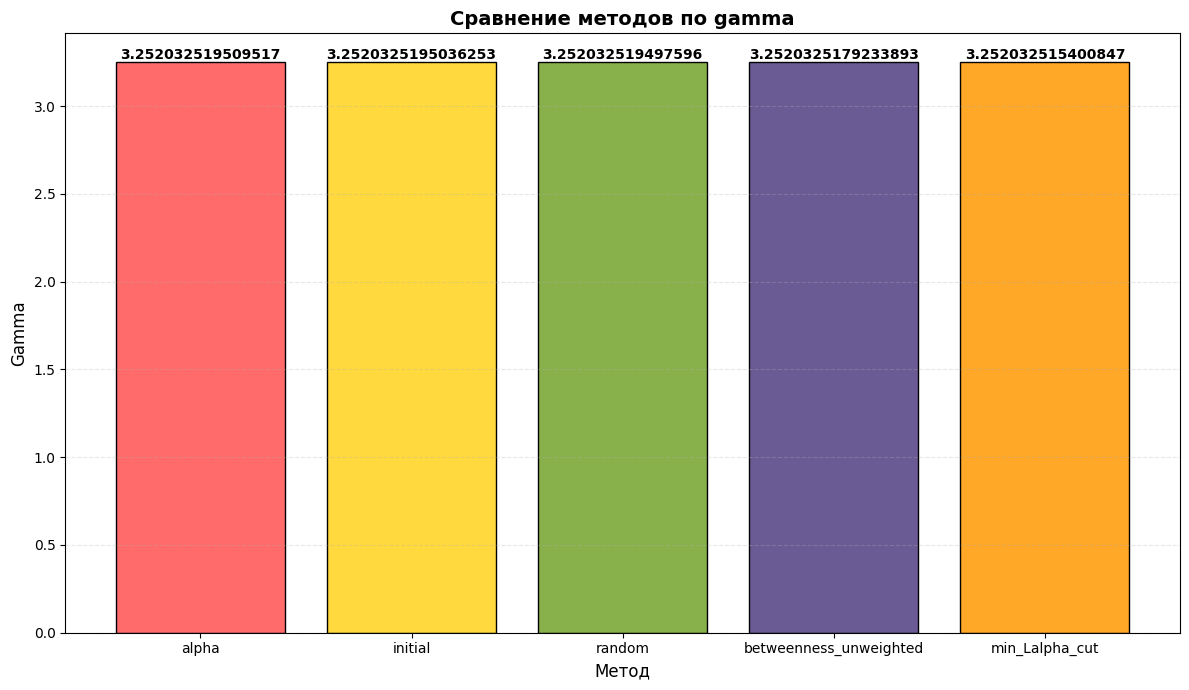

--------- Проводим тест на графе cola_t8 ---------

Добавим 4 новых мультиребер с capacity=80.0

Для графа cola_t8 результаты теста:

initial: 14.285714285295352
alpha: 15.384615382861192
random: 14.285714285129936
min_Lalpha_cut: 15.384615354889212
betweenness_unweighted: 14.28571426576951

Результаты gamma для типов в порядке убывания - от лучших к худшим: alpha, min_Lalpha_cut, initial, random, betweenness_unweighted




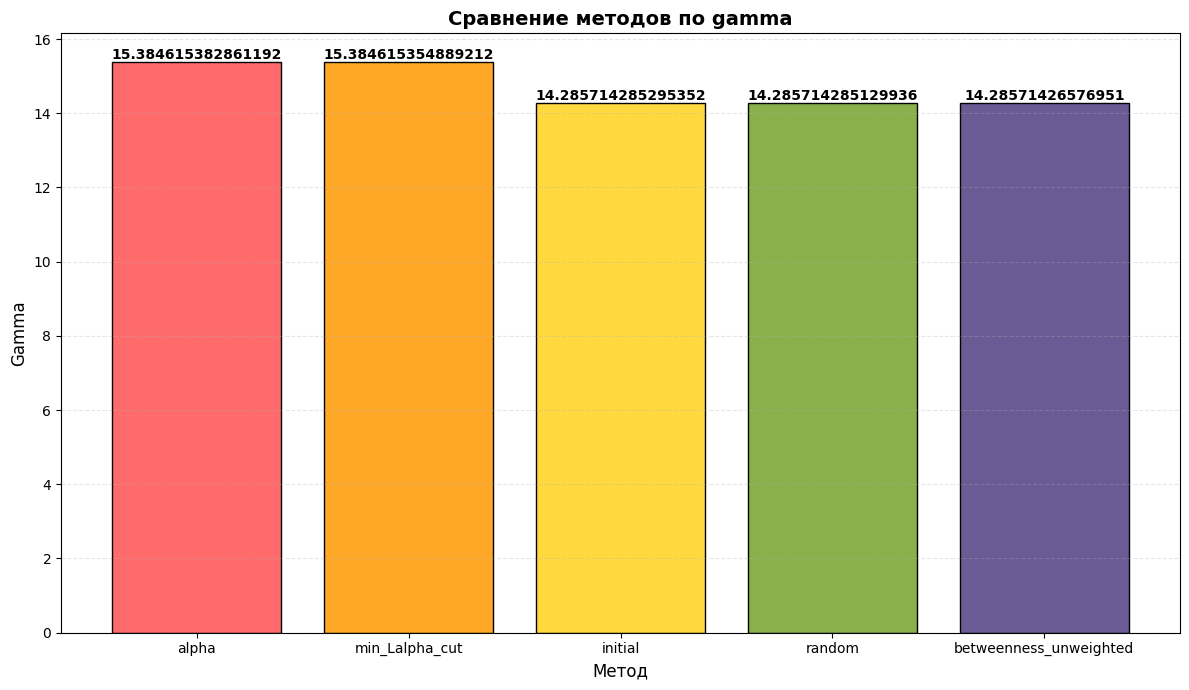

--------- Проводим тест на графе cola_t10 ---------

Добавим 5 новых мультиребер с capacity=80.0

Для графа cola_t10 результаты теста:

initial: 1.9999999996333915
alpha: 1.9999999999488534
random: 1.9999999994170425
min_Lalpha_cut: 1.999999999224
betweenness_unweighted: 1.9999999994984112

Результаты gamma для типов в порядке убывания - от лучших к худшим: alpha, initial, betweenness_unweighted, random, min_Lalpha_cut




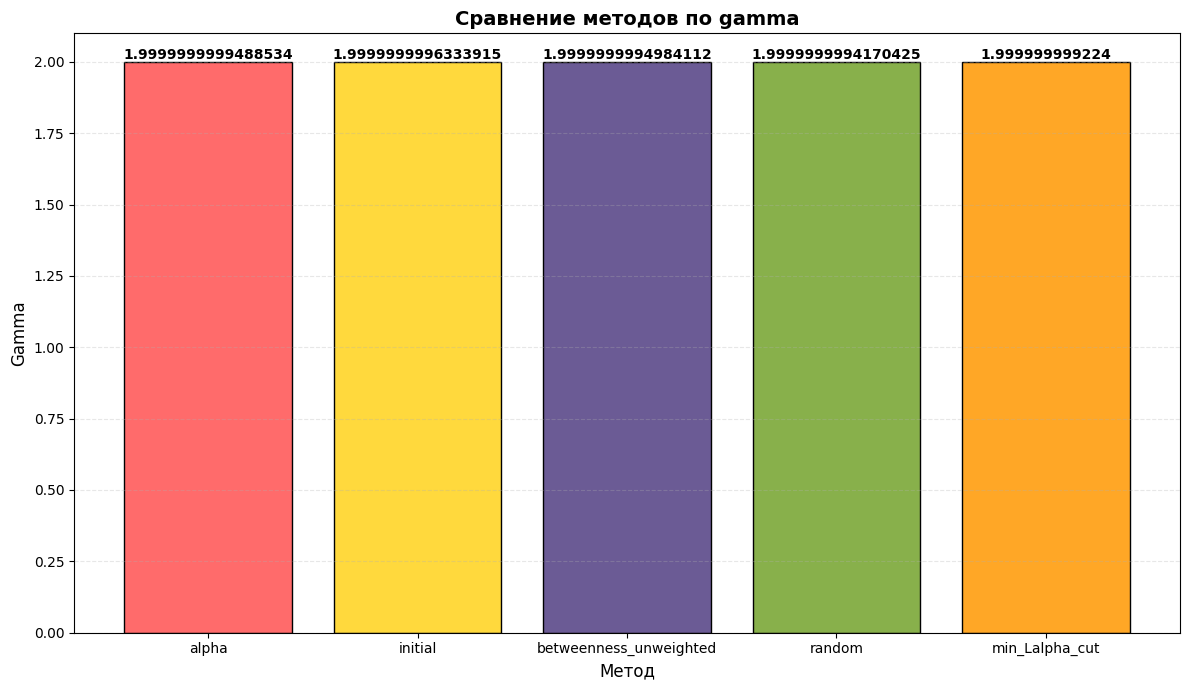

--------- Проводим тест на графе 2024_north ---------

Добавим 11 новых мультиребер с capacity=80.0

Для графа 2024_north результаты теста:

initial: 3.6781609194894105
alpha: 3.7209302312711405
random: 4.11428571344856
min_Lalpha_cut: 3.7209302325280005
betweenness_unweighted: 3.80952380947009

Результаты gamma для типов в порядке убывания - от лучших к худшим: random, betweenness_unweighted, min_Lalpha_cut, alpha, initial




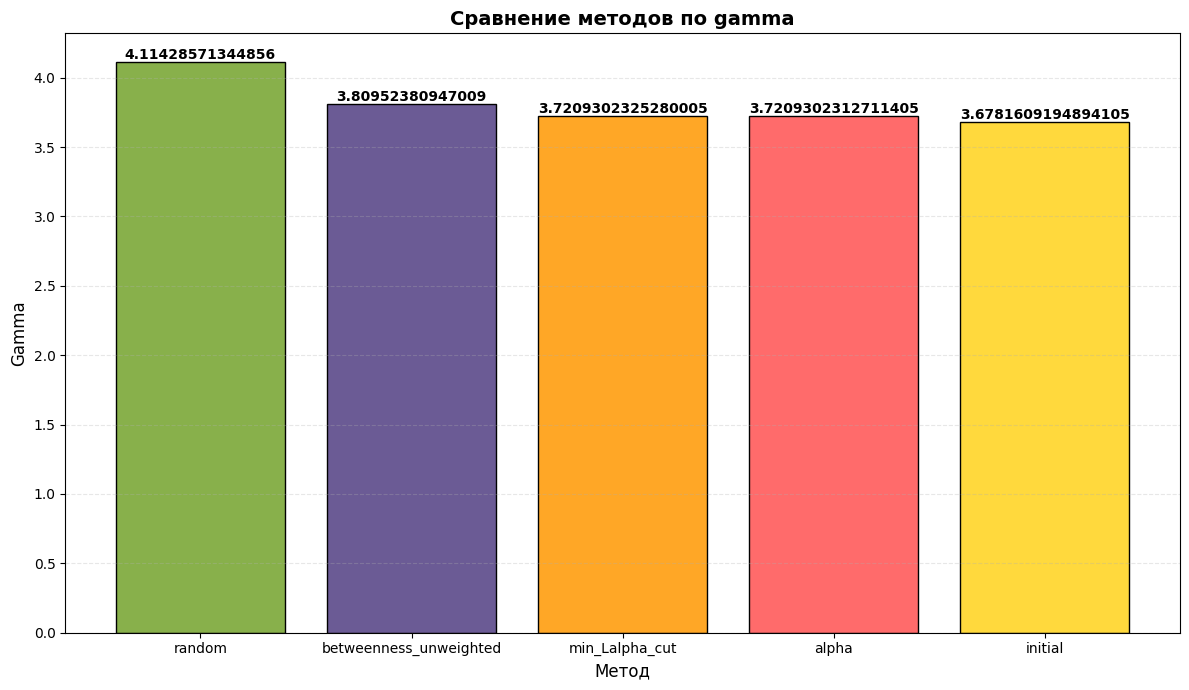

--------- Проводим тест на графе 2024_south ---------

Добавим 10 новых мультиребер с capacity=80.0

Для графа 2024_south результаты теста:

initial: 2.533936651405326
alpha: 2.8402366860562696
random: 2.5339366513352233
min_Lalpha_cut: 2.5339366507122594
betweenness_unweighted: 2.895927601702313

Результаты gamma для типов в порядке убывания - от лучших к худшим: betweenness_unweighted, alpha, initial, random, min_Lalpha_cut




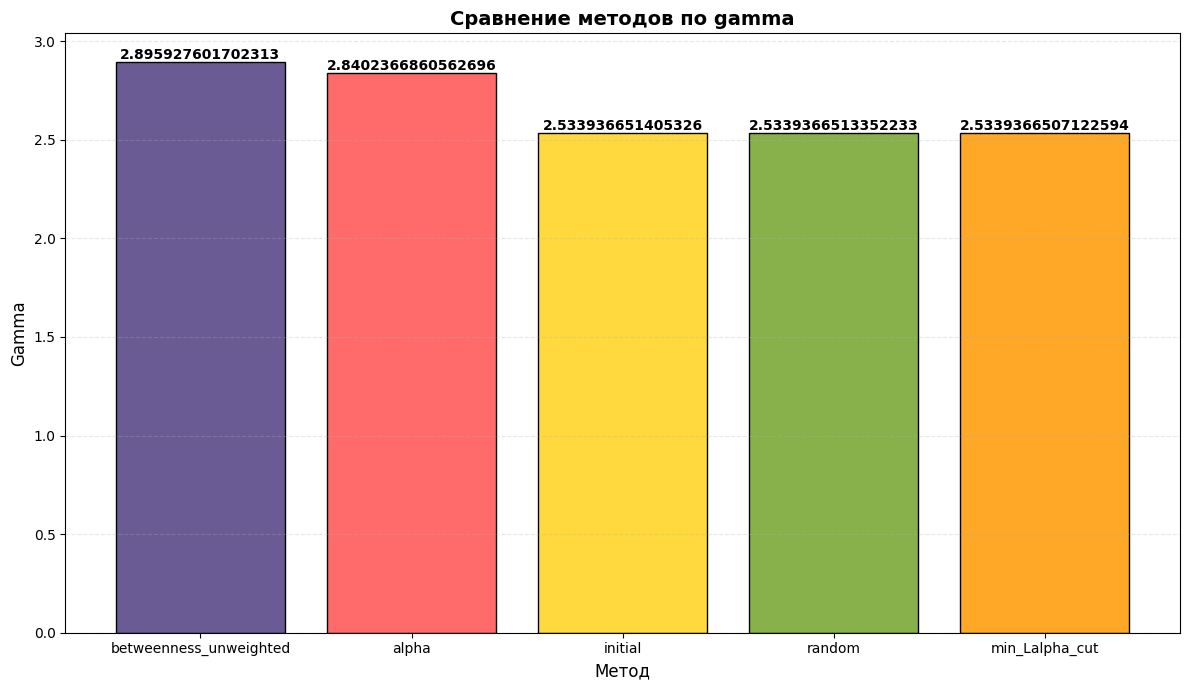

--------- Проводим тест на графе 2024_southwest ---------

Добавим 8 новых мультиребер с capacity=80.0

Для графа 2024_southwest результаты теста:

initial: 2.105263157826619
alpha: 2.105263157694161
random: 2.1052631578259526
min_Lalpha_cut: 2.1052631578133796
betweenness_unweighted: 2.1052631578625904

Результаты gamma для типов в порядке убывания - от лучших к худшим: betweenness_unweighted, initial, random, min_Lalpha_cut, alpha




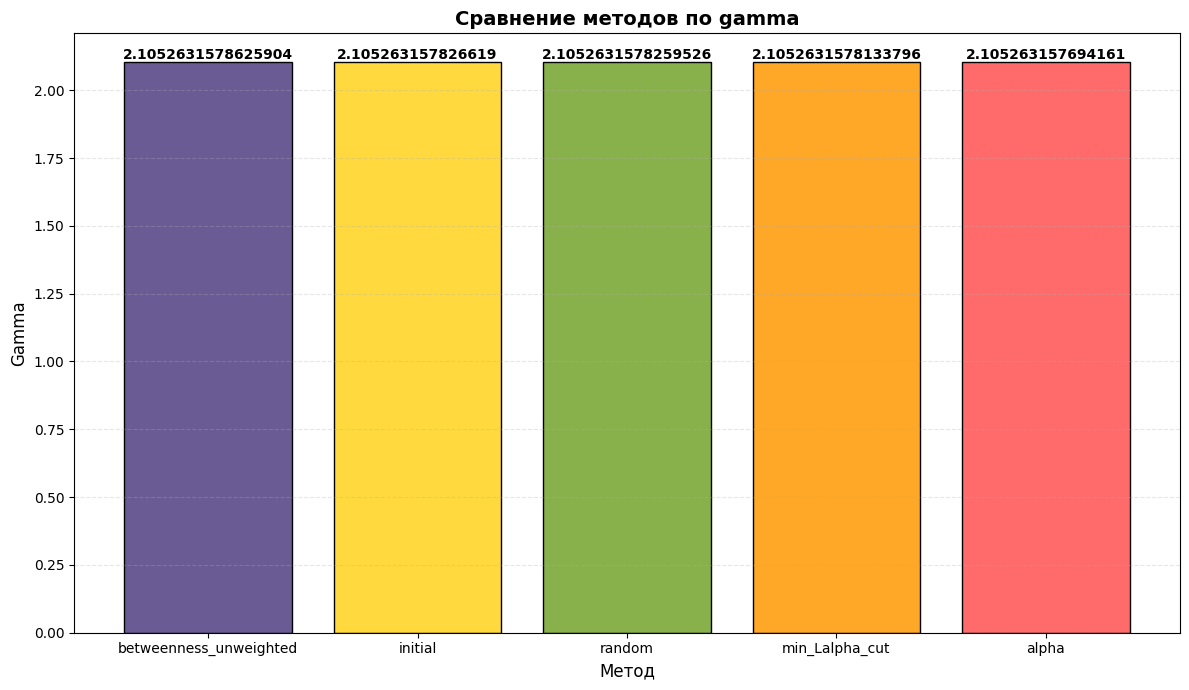

In [ ]:
import networkx as nx
import numpy as np

from graphmcfexps.expand_test import *

print(f'Доступные типы на распределение ресурсов: {get_available_types()}\n')
graphs_for_test_names = ['cola_t3', 'cola_t2', 'cola_t8', 'cola_t10', '2024_north', '2024_south', '2024_southwest']
graphs_for_test = get_hu_graphs(path_to_folder, graphs_for_test_names, True)
for name in graphs_for_test_names:
  graph = graphs_for_test[name]
  adj_graph, traffic_graph, capacity_value = graph['adj_graph'], graph['traffic_graph'], graph['capacity_value']
  graph_for_exp = GraphMCFexps(adj_graph, traffic_graph)
  print(f'--------- Проводим тест на графе {name} ---------\n')

  alpha_type = "min_Lalpha"
  number_in_mincut = get_number_in_mincut(graph_for_exp, alpha_type)
  number_to_add = number_in_mincut // 4
  print(f'Добавим {number_to_add} новых мультиребер с capacity={capacity_value}\n')
  additional_capacities = [capacity_value] * number_to_add

  results = []
  for type in get_available_types():
    if type != "min_cut":
      gamma = expand_network_test(additional_capacities, graph_for_exp, type, alpha_type) # здесь основная функция
      results.append((type, gamma))

  print(f'Для графа {name} результаты теста:\n\n{'\n'.join([str(type)+": "+str(gamma) for type, gamma in results])}\n')
  results.sort(key=lambda x: x[1], reverse=True)
  print(f'Результаты gamma для типов в порядке убывания - от лучших к худшим: {', '.join([str(type) for type, gamma in results])}\n\n')
  type_colors = {
        "alpha": "#FF6B6B",     # красный
        "initial": "#FFD93D",     # желтый
        "min_Lalpha_cut": "#FFA726",  # оранжевый
        "betweenness_unweighted": "#6B5B95",   # фиолетовый
        "random": "#88B04B"        # зеленый
    }
  visualize_with_bars(
        data=results,
        title="Сравнение методов по gamma",
        xlabel="Метод",
        ylabel="Gamma",
        color_dict=type_colors,
        show_values=True,
        figsize=(12, 7)
    )